# Use hh2 dataset to train a maching learning model

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

Import Dataset and remove variables where outcome is a nonstarter

In [2]:
hh = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Data_Wrangling/hh2.csv")

In [3]:
hh.shape

(70203, 30)

In [4]:
hh = hh[hh.unbanked >= 0]

In [5]:
hh = hh.dropna()

Identify all variables of interest for the testing:

In [6]:
#Unbanked, Children under 15, Previous bank usage, income, family type, age, unemployment, citizenship, immigrant status,race, income volitility, and internet access
["unbanked","hagele15","bank_prev","hhincome","hhtype","prtage","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet"]

['unbanked',
 'hagele15',
 'bank_prev',
 'hhincome',
 'hhtype',
 'prtage',
 'unemployed',
 'citizen',
 'native_born',
 'White_or_AAPI',
 'inc_vol',
 'internet']

Split the data by X and Y and prepare training sample

In [7]:
y = hh["unbanked"]
X = hh[["hagele15","bank_prev","hhincome","hhtype","prtage","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet"]]

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.1,random_state=1999)

In [9]:
# Let's 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [10]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,hagele15,bank_prev,hhincome,hhtype,prtage,unemployed,citizen,native_born,White_or_AAPI,inc_vol,internet
0,0.000000,0.0,1.00,0.8,0.025641,0.0,0.0,0.0,1.0,1.0,1.0
1,0.000000,0.0,1.00,0.8,0.769231,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.0,1.00,0.0,0.717949,0.0,0.0,0.0,0.0,0.0,1.0
3,0.222222,0.0,1.00,0.0,0.410256,0.0,0.0,0.0,1.0,0.0,1.0
4,0.111111,0.0,0.25,0.0,0.487179,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16347,0.111111,0.0,1.00,0.0,0.564103,0.0,0.0,0.0,1.0,0.0,1.0
16348,0.000000,0.0,0.50,0.6,0.564103,0.0,0.0,0.0,0.0,0.0,1.0
16349,0.000000,0.0,0.00,0.2,0.384615,0.0,0.0,0.0,0.0,1.0,1.0
16350,0.111111,0.0,0.75,0.0,0.615385,0.0,0.0,0.0,0.0,1.0,1.0


In [11]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["hagele15","bank_prev","hhincome","hhtype","prtage","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['hagele15',
                                                                          'bank_prev',
                                                                          'hhincome',
                                                                          'hhtype',
                                                                          'prtage',
                                                                          'unemployed',
                                                                          'citizen',
                                                                          'native_born',
                    

In [12]:
search.best_score_

-0.0221183168183224

In [13]:
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

In [14]:
pred_y = search.predict(test_X)

In [15]:
m.mean_squared_error(test_y,pred_y)

0.02629279498804594

In [16]:
m.r2_score(test_y,pred_y)

0.48962633651833354

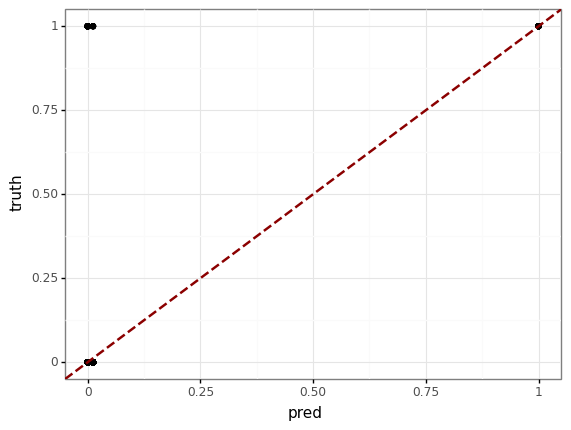

<ggplot: (8786157372097)>

In [19]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() 
)